# BorgWarner Project

### Import Statements

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

### Pre-Processing

In [36]:
df = pd.read_csv('dados_por_tratar_v13.xlsx - Sheet1.csv')
df = df.drop(columns=['ts', 'Id','IdContexto'])
df

,tensao_media_solda1,tensao_pico_solda1,corrente_media_solda1,tempo_solda1,energia_solda1,profundidade_solda1,prof_fecho_solda1,tensao_media_solda2,tensao_pico_solda2,corrente_media_solda2,...,profundidade_solda2,prof_fecho_solda2,tensao_media_solda3,tensao_pico_solda3,corrente_media_solda3,tempo_solda3,energia_solda3,profundidade_solda3,prof_fecho_solda3,resultado
0,889,1432,823,140,125859,85,1740,828,1280,703,...,85,1738,865,1432,777,132,110299,86,1730,1
1,842,1392,788,134,108743,85,1745,851,1264,694,...,85,1733,861,1424,774,131,108109,86,1759,1
2,879,1408,761,129,105850,85,1735,864,1400,750,...,85,1739,889,1460,826,140,129942,85,1764,1
3,888,1348,734,124,96457,85,1729,845,1296,689,...,85,1748,886,1412,757,128,105754,85,1779,1
4,815,1336,746,126,96573,85,1746,834,1252,666,...,85,1731,865,1412,764,130,105151,86,1714,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134622,786,1028,1143,37,35665,119,2386,759,1048,1370,...,119,2476,744,904,1334,98,100074,119,2374,2
134623,741,1028,1113,33,30385,115,2443,750,1048,1370,...,106,2495,760,1072,1286,69,70238,116,2420,1
134624,697,8184,186,5,1554,1,3044,0,0,0,...,0,0,0,0,0,0,0,0,0,2
134625,165,2036,3,2,10,0,3035,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [37]:
df['resultado'] = df['resultado'].replace({1: 0, 2: 1})

In [38]:
# Define the features and target variable
X = df.drop(columns=['resultado'])
y = df['resultado']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [40]:
y_train_smote.value_counts()

0    85075
1    85075
Name: resultado, dtype: int64

In [41]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### XgBoost Model

In [46]:
# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'logloss'
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred = bst.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

In [45]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred_binary)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
f1 = f1_score(y_test, y_pred_binary)
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

# Print metrics
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.9347842234271707
F1 Score: 0.5259
Sensitivity (Recall): 0.3766
Specificity: 0.9941


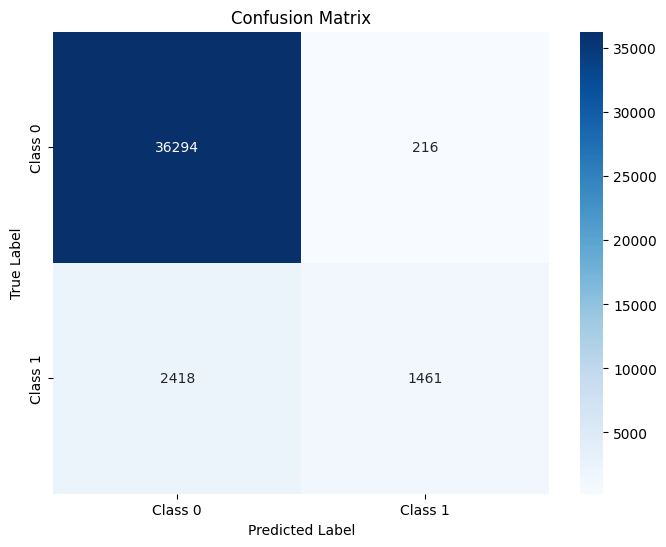

In [49]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()